In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
from glob import glob

In [3]:
big = pd.concat(pd.read_csv(fname) for fname in glob('data/rep6/rep6-*.csv'))

In [4]:
big.shape

(53520485, 5)

In [85]:
import scipy.io

In [86]:
cellBoundaries = scipy.io.loadmat('data/rep6/cellBoundaries.mat')

In [102]:
cellBoundaries['cellBoundaries'][0][12][-3][0, 0], \
cellBoundaries['cellBoundaries'][0][12][-2][0, 0], \
cellBoundaries['cellBoundaries'][0][12][-1][0, 0]

(166.75416576000003, 890.77060800000015, 13)

In [119]:
big_sample_info = pd.DataFrame(np.zeros((cellBoundaries['cellBoundaries'][0].shape[0], 3)), columns=['nucleusArea', 'cytoplasmArea', 'cellID'])
for i in big_sample_info.index:
    row = \
    cellBoundaries['cellBoundaries'][0][i][-3][0, 0], \
    cellBoundaries['cellBoundaries'][0][i][-2][0, 0], \
    cellBoundaries['cellBoundaries'][0][i][-1][0, 0]
    
    big_sample_info.loc[i, :] = row
    
big_sample_info.cellID = big_sample_info.cellID.astype(int64)
big_sample_info = big_sample_info.set_index('cellID')

In [60]:
middle = big.query('-450 < abs_X < 600 & -450 < abs_Y < 600')

In [61]:
middle.cellID.unique().shape

(1123,)

In [63]:
codebook = pd.read_csv('data/codebook.csv', skiprows=3)

In [64]:
codebook['barcode_id'] = codebook.index + 1

In [65]:
codebook.head()

name  id           barcode  barcode_id
0   Blank-1        11100000001000           1
1  Blank-10      1001100100000000           2
2   Blank-2        11000100100000           3
3   Blank-3        11010001000000           4
4   Blank-4        10010000001100           5

In [66]:
middle = middle.merge(codebook[['name', 'barcode_id']], on='barcode_id')

Make huge picture of all data

In [67]:
N = 1000

X_intervals, X_bins = pd.cut( big['abs_X'].unique(), N, retbins=True)
Y_intervals, Y_bins = pd.cut( big['abs_Y'].unique(), N, retbins=True)

In [68]:
xx = np.array([-450, -450, 600, 600, -450])
yy = np.array([-450, 600, 600, -450, -450])

In [69]:
xx_img = np.less.outer(X_bins, xx).sum(0) * (N / (N + 1))
yy_img = np.less.outer(Y_bins, yy).sum(0) * (N / (N + 1))

In [70]:
tmp = big

grid_counts = tmp.groupby( [pd.cut( tmp['abs_X'], N), pd.cut( tmp['abs_Y'], N)] ).count()['abs_X'].to_frame()
img_mat = grid_counts.unstack().replace(np.nan, 0)

In [71]:
codebook.query('name == "MALAT1"')

name                  id          barcode  barcode_id
127  MALAT1   ENST00000534336.1  100000000010101         128

In [72]:
tmp = big.query('barcode_id == 128')

In [73]:
grid_counts = tmp.groupby( [pd.cut( tmp['abs_X'], N), pd.cut( tmp['abs_Y'], N)] ).count()['abs_X'].to_frame()
img_mat_malat = grid_counts.unstack().replace(np.nan, 0)

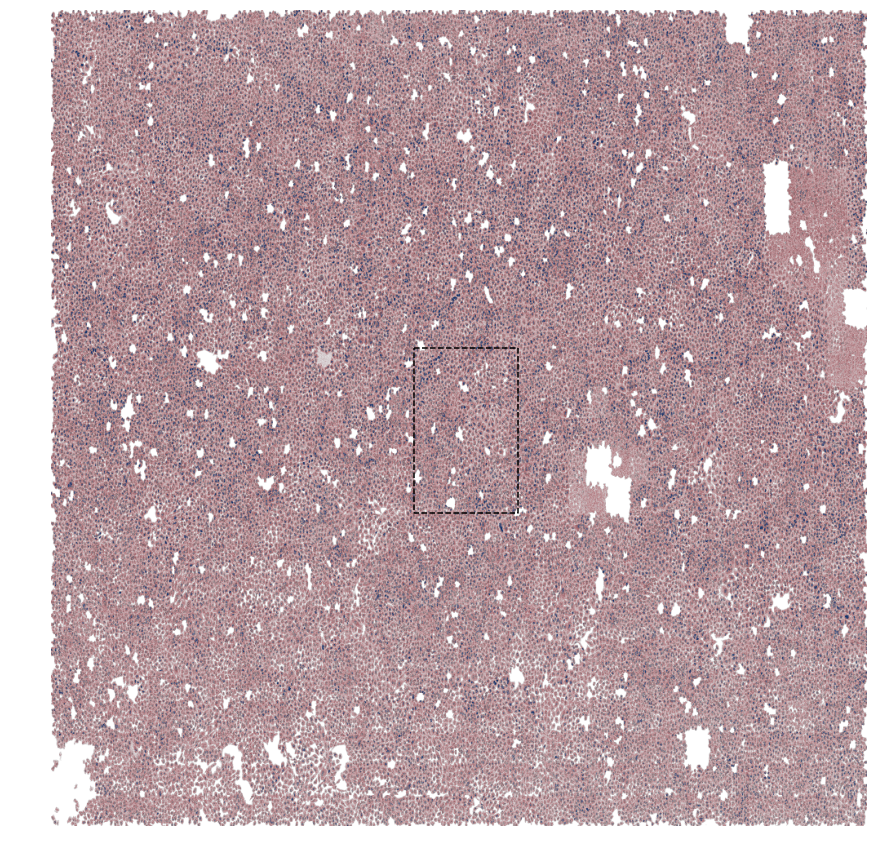

In [74]:
figsize(15, 15)
final_img = cm.Purples(img_mat / img_mat.max())
final_img[:, :, :] = cm.Reds(255)
final_img[:, :, 3] = img_mat / img_mat.max() * 0.66

tmp_img = cm.Blues(img_mat_malat / img_mat_malat.max())
tmp_img[:, :, :] = cm.Blues(255)
tmp_img[:, :, 3] = img_mat_malat / img_mat_malat.max()

plt.imshow(final_img, interpolation='hermite');
plt.imshow(tmp_img, interpolation='hermite');
plt.axis('equal');
plt.axis('off');

plt.plot(yy_img, xx_img, ls='--', c='k');

Make zoomed in image

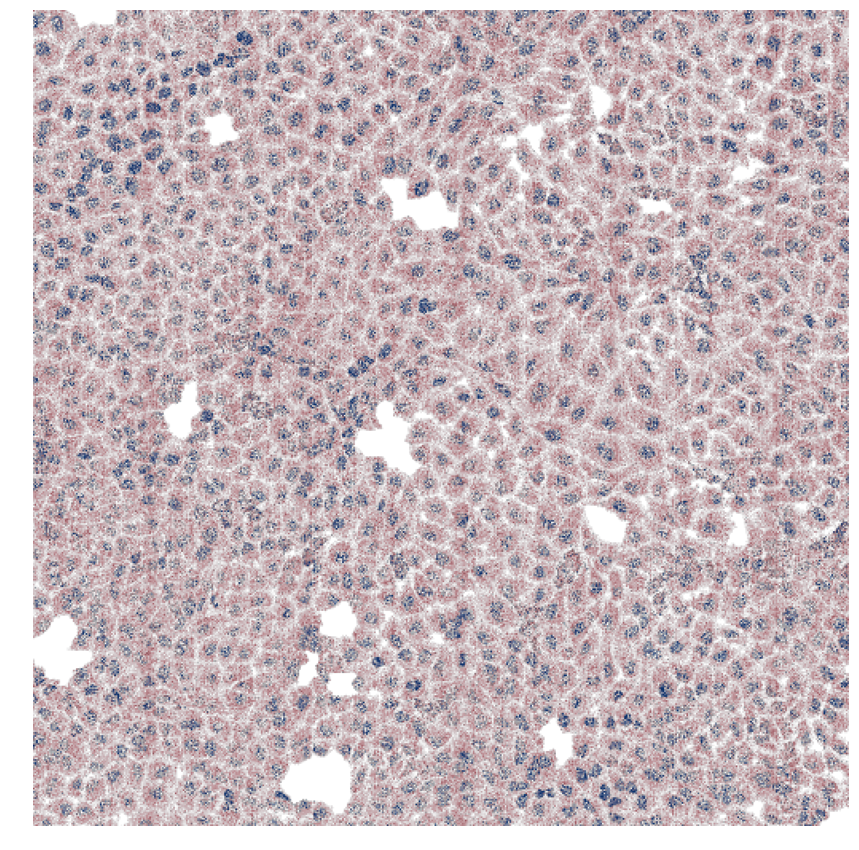

In [75]:
N = 512

tmp = middle


grid_counts = tmp.groupby( [pd.cut( tmp['abs_X'], N), pd.cut( tmp['abs_Y'], N)] ).count()['abs_X'].to_frame()
img_mat = grid_counts.unstack().replace(np.nan, 0)

final_img = cm.Purples(img_mat / img_mat.max())
final_img[:, :, :] = cm.Reds(255)
final_img[:, :, 3] = img_mat / img_mat.max() * 0.66

tmp = middle.query('name == "MALAT1"')

grid_counts = tmp.groupby( [pd.cut( tmp['abs_X'], N), pd.cut( tmp['abs_Y'], N)] ).count()['abs_X'].to_frame()
img_mat = grid_counts.unstack().replace(np.nan, 0)

tmp_img = cm.Blues(img_mat / img_mat.max())
tmp_img[:, :, :] = cm.Blues(255)
tmp_img[:, :, 3] = img_mat / img_mat.max()
# final_img += tmp_img

plt.imshow(final_img, interpolation='hermite');
plt.imshow(tmp_img, interpolation='hermite')
plt.axis('off');

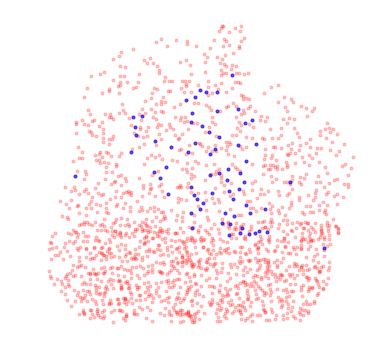

In [78]:
sample_cell = middle.cellID.sample().iloc[0]
a_cell = middle.query('cellID == {}'.format(sample_cell))

figsize(6, 6)
plt.scatter(a_cell.abs_X, a_cell.abs_Y, alpha=0.22, c='red', marker='.');
a_nucleus = a_cell.query('name == "MALAT1"')
plt.scatter(a_nucleus.abs_X, a_nucleus.abs_Y, alpha=0.6, c='blue', marker='.');
plt.axis('off');

In [120]:
sample_info = \
middle.groupby(['cellID']) \
    .mean()[['abs_X', 'abs_Y']]

In [124]:
sample_info = sample_info.join(big_sample_info)

In [125]:
X_intervals, X_bins = pd.cut( middle['abs_X'].unique(), N, retbins=True)
Y_intervals, Y_bins = pd.cut( middle['abs_Y'].unique(), N, retbins=True)

In [126]:
xx_img = np.less.outer(X_bins, sample_info.abs_X).sum(0) * (N / (N + 1))
yy_img = np.less.outer(Y_bins, sample_info.abs_Y).sum(0) * (N / (N + 1))

In [127]:
np.less.outer(X_bins, sample_info.abs_X)

array([[ True,  True,  True, ...,  True,  True,  True],
       [False,  True,  True, ...,  True,  True,  True],
       [False, False,  True, ...,  True,  True,  True],
       ..., 
       [False, False, False, ..., False,  True,  True],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool)

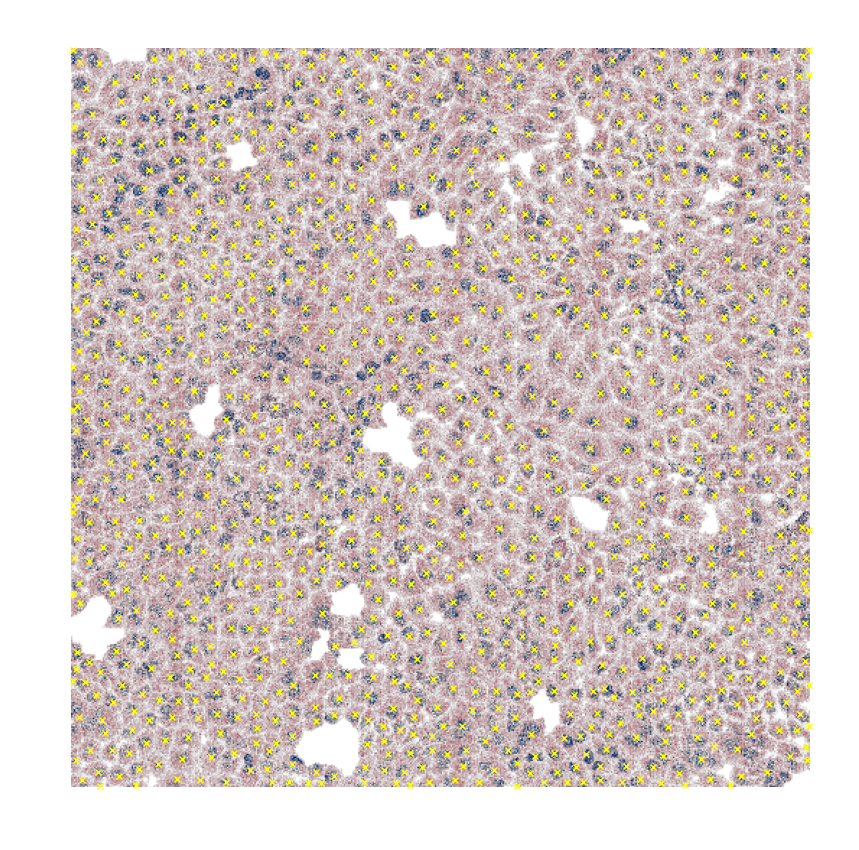

In [128]:
figsize(15, 15)

plt.imshow(final_img, interpolation='hermite');
plt.imshow(tmp_img, interpolation='hermite')

plt.scatter(yy_img, xx_img, marker='x', c='yellow');
plt.axis('off');

Make cell level expression

In [129]:
exp_mat = \
middle.groupby(['cellID', 'name']) \
    .count() \
    .iloc[:, 0] \
    .unstack() \
    .replace(np.nan, 0.0)

In [130]:
exp_mat = exp_mat.T[exp_mat.sum(0) >= 3].T

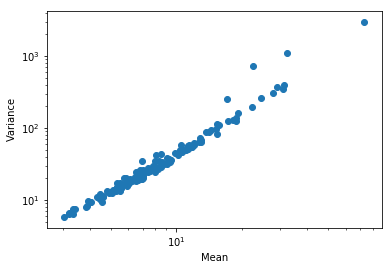

In [131]:
figsize(6, 4)
plt.loglog()
plt.scatter(exp_mat.mean(), exp_mat.var());
plt.xlabel('Mean')
plt.ylabel('Variance');

In [209]:
import NaiveDE

In [210]:
dfm = NaiveDE.stabilize(exp_mat)

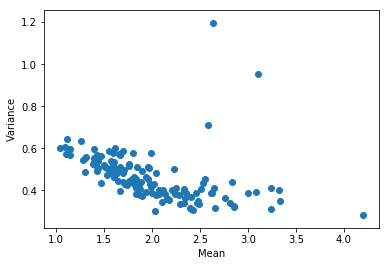

In [211]:
plt.scatter(dfm.mean(), dfm.var());
plt.xlabel('Mean')
plt.ylabel('Variance');

In [136]:
dfm = np.log10(exp_mat + 1.)

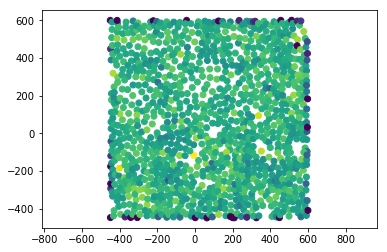

In [137]:
plt.scatter(sample_info.abs_X, sample_info.abs_Y, c=dfm['MALAT1']);
plt.axis('equal');

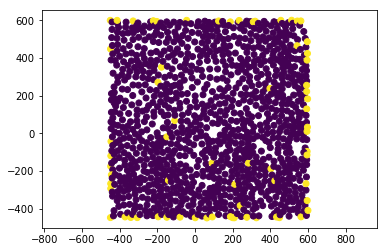

In [138]:
plt.scatter(sample_info.abs_X, sample_info.abs_Y, c=exp_mat['MALAT1'] < 20);
plt.axis('equal');

In [139]:
sample_info = sample_info[~(exp_mat['MALAT1'] < 20)]

In [140]:
exp_mat = exp_mat.loc[sample_info.index]

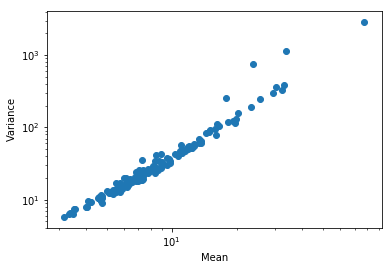

In [212]:
figsize(6, 4)
plt.loglog()
plt.scatter(exp_mat.mean(), exp_mat.var());
plt.xlabel('Mean')
plt.ylabel('Variance');

In [213]:
dfm = NaiveDE.stabilize(exp_mat)

In [231]:
res = NaiveDE.regress_out(sample_info, dfm.T, 'np.log10(cytoplasmArea)').T

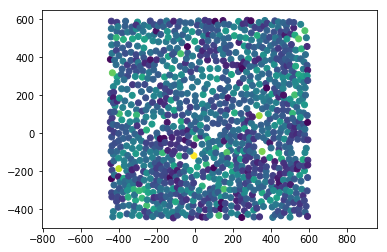

In [235]:
plt.scatter(sample_info.abs_X, sample_info.abs_Y, c=dfm['MALAT1']);
plt.axis('equal');

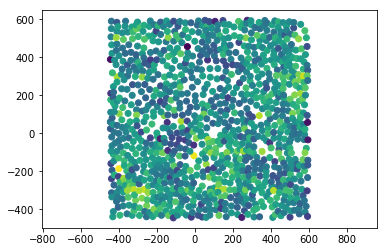

In [236]:
plt.scatter(sample_info.abs_X, sample_info.abs_Y, c=res['MALAT1']);
plt.axis('equal');

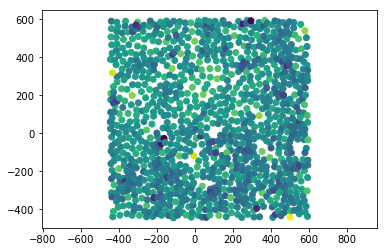

In [238]:
plt.scatter(sample_info.abs_X, sample_info.abs_Y, c=np.log10(sample_info.cytoplasmArea));
plt.axis('equal');

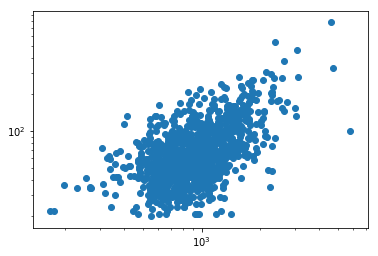

In [245]:
plt.yscale('log')
plt.xscale('log')
plt.scatter(sample_info.cytoplasmArea, exp_mat['MALAT1']);

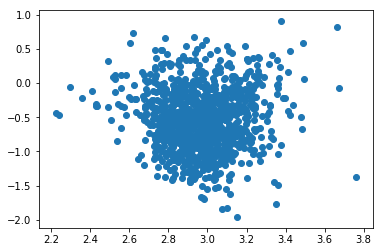

In [243]:
plt.scatter(np.log10(sample_info.cytoplasmArea), res['MALAT1']);

In [163]:
n_exp_mat = (exp_mat.T / (sample_info.cytoplasmArea + sample_info.nucleusArea).T).T

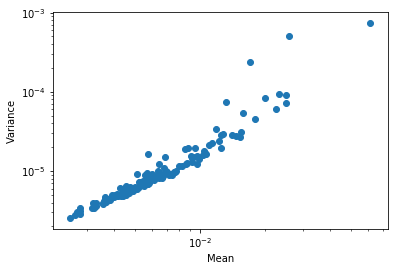

In [164]:
figsize(6, 4)
plt.loglog()
plt.scatter(n_exp_mat.mean(), n_exp_mat.var());
plt.xlabel('Mean')
plt.ylabel('Variance');

In [165]:
dfm = np.log10(n_exp_mat + 1.)

In [207]:
exp_mat.to_csv('data/rep6/middle_exp_mat.csv')

In [208]:
sample_info.to_csv('data/rep6/middle_sample_info.csv')

In [221]:
X = sample_info[['abs_X', 'abs_Y']]

In [222]:
import SpatialDE as sde

In [223]:
results = sde.run(X, dfm, pvalues=True)

INFO:root:Performing DE test
INFO:root:Pre-calculating USU^T = K's ...
INFO:root:Done: 5.4s
INFO:root:Fitting gene models
INFO:root:Model 1 of 20
INFO:root:Model 2 of 20                          
INFO:root:Model 3 of 20                           
INFO:root:Model 4 of 20                           
INFO:root:Model 5 of 20                           
INFO:root:Model 6 of 20                          
INFO:root:Model 7 of 20                           
INFO:root:Model 8 of 20                           
INFO:root:Model 9 of 20                          
INFO:root:Model 10 of 20                         
INFO:root:Model 11 of 20                         
INFO:root:Model 12 of 20                          
INFO:root:Model 13 of 20                          
INFO:root:Model 14 of 20                          
INFO:root:Model 15 of 20                         
INFO:root:Model 16 of 20                          
INFO:root:Model 17 of 20                          
INFO:root:Model 18 of 20                    

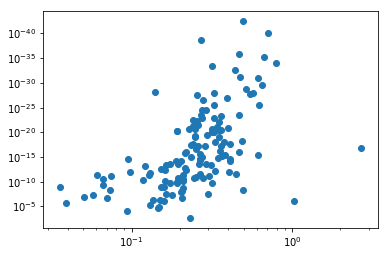

In [224]:
figsize(6, 4)
plt.loglog()
plt.scatter(results.max_s2_t_hat, results.pval)
plt.gca().invert_yaxis();

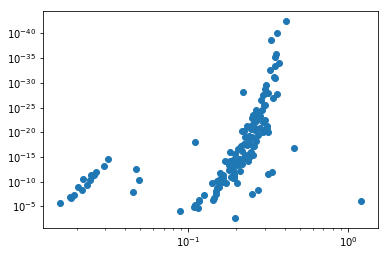

In [227]:
figsize(6, 4)
plt.loglog()
plt.scatter(1./results.max_delta, results.pval)
plt.gca().invert_yaxis();

In [246]:
results = sde.run(X, res, pvalues=True)

INFO:root:Performing DE test
INFO:root:Pre-calculating USU^T = K's ...
INFO:root:Done: 5.5s
INFO:root:Fitting gene models
INFO:root:Model 1 of 20
INFO:root:Model 2 of 20                          
INFO:root:Model 3 of 20                           
INFO:root:Model 4 of 20                           
INFO:root:Model 5 of 20                           
INFO:root:Model 6 of 20                           
INFO:root:Model 7 of 20                           
INFO:root:Model 8 of 20                          
INFO:root:Model 9 of 20                          
INFO:root:Model 10 of 20                         
INFO:root:Model 11 of 20                          
INFO:root:Model 12 of 20                          
INFO:root:Model 13 of 20                         
INFO:root:Model 14 of 20                          
INFO:root:Model 15 of 20                          
INFO:root:Model 16 of 20                          
INFO:root:Model 17 of 20                          
INFO:root:Model 18 of 20                   

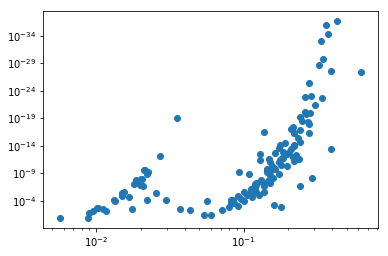

In [247]:
figsize(6, 4)
plt.loglog()
plt.scatter(1./results.max_delta, results.pval)
plt.gca().invert_yaxis();

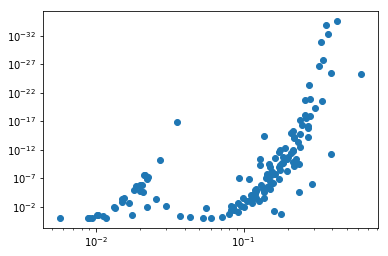

In [248]:
figsize(6, 4)
plt.loglog()
plt.scatter(1./results.max_delta, results.qval)
plt.gca().invert_yaxis();

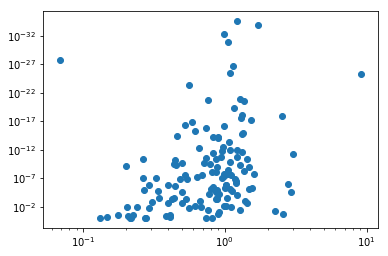

In [249]:
figsize(6, 4)
plt.loglog()
plt.scatter(results.max_s2_t_hat, results.qval)
plt.gca().invert_yaxis();

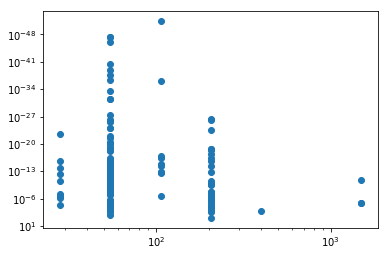

In [173]:
plt.loglog()
plt.scatter(results.l, results.pval)
plt.gca().invert_yaxis();

In [174]:
results.sort_values('qval', ascending=True).head()

g  max_delta     max_ll_x  max_mu_hat  max_s2_t_hat     n      time  \
96      BSN   2.213556  5825.805226    0.001718  4.355681e-07  1056  0.000747   
80   SPTBN1   2.268608  4399.025806    0.009694  1.025779e-05  1056  0.000851   
77  SMARCA5   2.224020  5108.832363    0.005182  2.831707e-06  1056  0.000906   
63    PRKDC   2.449005  4402.523898    0.010514  1.074890e-05  1056  0.000830   
42     FASN   2.456590  4441.046443    0.008338  8.156851e-06  1056  0.000826   

             l  M model           BIC     max_ll_y          D          pval  \
96  105.856034  4    SE -11623.761477  5729.468159  96.337067  2.659976e-52   
80   54.555049  4    SE  -8770.202639  4310.160638  88.865168  3.340349e-48   
77   54.555049  4    SE -10189.815751  5020.379898  88.452465  5.625256e-48   
63   54.555049  4    SE  -8777.198821  4316.311046  86.212852  9.514351e-47   
42   54.555049  4    SE  -8854.243912  4364.905287  76.141155  3.159438e-41   

            qval  
96  3.723966e-50  
80  4.676489e-46  
77  7.875358e-46  
63  1.332009e-44  
42  4.423213e-39

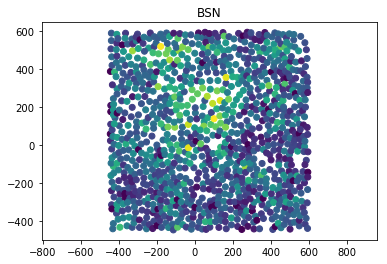

In [197]:
plt.scatter(sample_info.abs_X, sample_info.abs_Y, c=dfm['BSN']);
plt.axis('equal');
plt.title('BSN')
# plt.colorbar();

In [176]:
10 ** 1.4 - 1

24.118864315095795

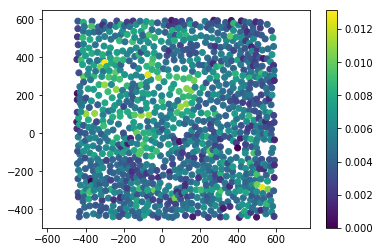

In [177]:
plt.scatter(sample_info.abs_X, sample_info.abs_Y, c=dfm['SMARCA5']);
plt.axis('equal');
plt.colorbar()

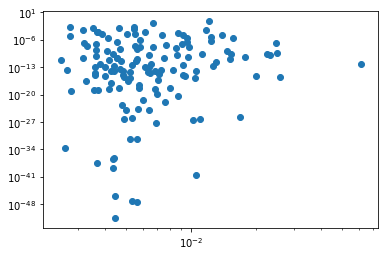

In [204]:
figsize(6, 4)
plt.loglog()
plt.scatter(n_exp_mat.mean(), results.pval);

In [178]:
N = 5
top_per_ls = results \
    .sort_values('qval') \
    .groupby('l') \
    .head(N) \
    .sort_values(['l', 'qval'], ascending=[True, True])

top_per_ls

g  max_delta     max_ll_x  max_mu_hat  max_s2_t_hat     n  \
3           CENPF   1.882511  3867.621360    0.007377  2.273729e-05  1056   
5           MYH10   2.329497  4970.177605    0.006306  7.215675e-06  1056   
0            AFF4   2.806585  5272.938155    0.004126  3.017316e-06  1056   
4           HERC2   2.907663  5285.965143    0.004206  3.037065e-06  1056   
6           NRIP1   3.396875  5521.664382    0.002416  1.118243e-06  1056   
80         SPTBN1   2.268608  4399.025806    0.009694  1.025779e-05  1056   
77        SMARCA5   2.224020  5108.832363    0.005182  2.831707e-06  1056   
63          PRKDC   2.449005  4402.523898    0.010514  1.074890e-05  1056   
42           FASN   2.456590  4441.046443    0.008338  8.156851e-06  1056   
52         MALAT1   2.676412  3336.563444    0.024873  6.609503e-05  1056   
96            BSN   2.213556  5825.805226    0.001718  4.355681e-07  1056   
97       C17orf51   2.873984  5687.847439    0.002152  4.715535e-07  1056   
102          USP8   5.762318  5994.797132    0.001465  1.481993e-07  1056   
98           CNR2   4.349402  5647.712176    0.002388  3.826171e-07  1056   
104        ZCCHC6   5.714119  5556.692897    0.003050  4.183718e-07  1056   
122        KIF13B  22.642628  5472.405814    0.002987  4.623849e-07  1056   
135         USP9X  23.583469  4978.623304    0.006105  1.734522e-06  1056   
106        GTF3C4   5.488758  5446.128957    0.003146  4.054057e-07  1056   
126        RNF152  27.409552  5826.311767    0.001947  1.681052e-07  1056   
128  RP4-671O14.6  29.575607  5865.912038    0.001771  1.320544e-07  1056   
136         YIPF4  84.376998  5815.608264    0.002011  5.864123e-08  1056   
137         BRCA2  17.319680  5766.078612    0.001902  2.646112e-07  1056   
138       HEATR5B  33.476971  5784.653338    0.002094  1.585427e-07  1056   
139      KIAA1462  37.012625  5736.080292    0.002084  1.450495e-07  1056   

         time            l  M model           BIC     max_ll_y          D  \
3    0.000867    28.116048  4    SE  -7707.393747  3824.285800  43.335560   
5    0.000845    28.116048  4    SE  -9912.506237  4939.284520  30.893085   
0    0.000969    28.116048  4    SE -10518.027335  5245.586455  27.351699   
4    0.000832    28.116048  4    SE -10544.081312  5261.570695  24.394448   
6    0.001313    28.116048  4    SE -11015.479791  5500.327456  21.336926   
80   0.000851    54.555049  4    SE  -8770.202639  4310.160638  88.865168   
77   0.000906    54.555049  4    SE -10189.815751  5020.379898  88.452465   
63   0.000830    54.555049  4    SE  -8777.198821  4316.311046  86.212852   
42   0.000826    54.555049  4    SE  -8854.243912  4364.905287  76.141155   
52   0.000896    54.555049  4    SE  -6645.277915  3263.361176  73.202268   
96   0.000747   105.856034  4    SE -11623.761477  5729.468159  96.337067   
97   0.000860   105.856034  4    SE -11347.845905  5619.715000  68.132439   
102  0.000852   105.856034  4    SE -11961.745291  5961.642259  33.154874   
98   0.001010   105.856034  4    SE -11267.575378  5615.717240  31.994936   
104  0.000908   105.856034  4    SE -11085.536819  5527.256176  29.436720   
122  0.000832   205.398037  4   PER -10916.962654  5422.028206  50.377608   
135  0.000892   205.398037  4   PER  -9929.397635  4928.564472  50.058833   
106  0.000704   205.398037  4    SE -10864.408939  5400.894186  45.234771   
126  0.001613   205.398037  4   PER -11624.774560  5789.905862  36.405905   
128  0.001598   205.398037  4   PER -11703.975102  5829.595804  36.316234   
136  0.001856   398.544628  4   PER -11603.367553  5808.711598   6.896666   
137  0.001307  1500.507945  4   PER -11504.308251  5744.525343  21.553269   
138  0.000583  1500.507945  4   PER -11541.457702  5774.011694  10.641644   
139  0.000629  1500.507945  4   PER -11444.311611  5725.532463  10.547829   

             pval          qval  
3    2.776636e-23  3.887290e-21  
5    1.652378e-16  2.313329e-14  
0    1.380297e-14  1.932416e-12  
4    5.516608e-13  7.723251e

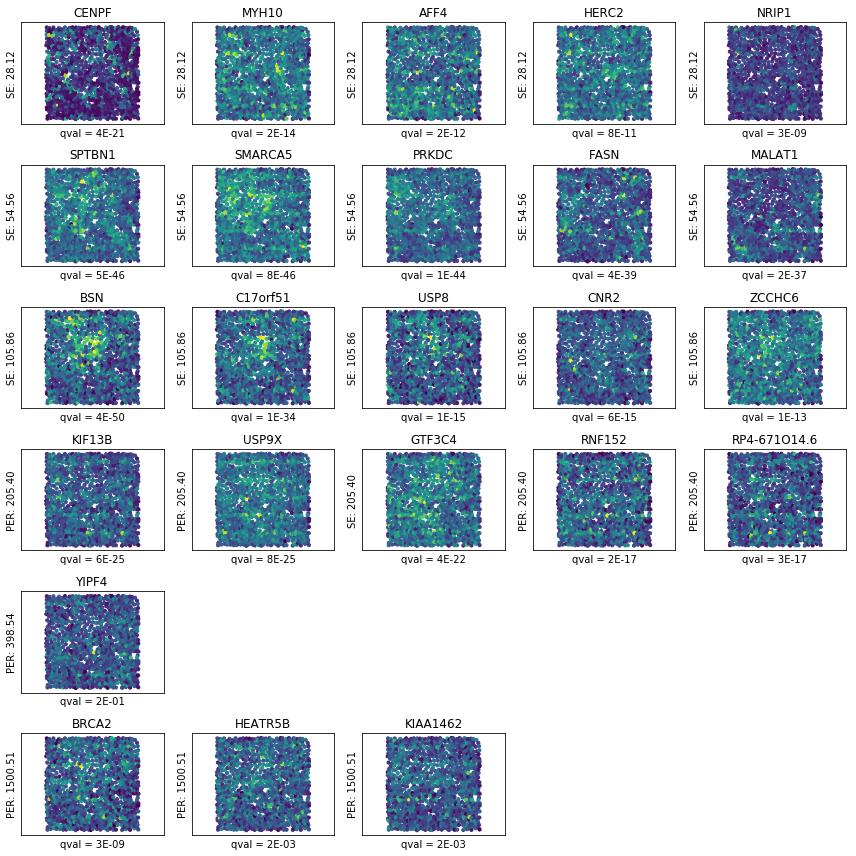

In [179]:
figsize(12, 12)
N_rows = top_per_ls['l'].unique().shape[0]
for j, T in enumerate(top_per_ls.groupby('l')):
    _, group = T
    for i, idx in enumerate(group.index):
        r = top_per_ls.loc[idx]
        plt.subplot(N_rows, N, j * N + i + 1)
        plt.scatter(sample_info.abs_X, sample_info.abs_Y, c=dfm[r['g']], s=10, rasterized=True);
        plt.title(r['g'])
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('qval = {:.0E}'.format(r['qval']))
        plt.ylabel('{}: {:.2f}'.format(r['model'], r['l']))
        plt.axis('equal')
        
plt.tight_layout()

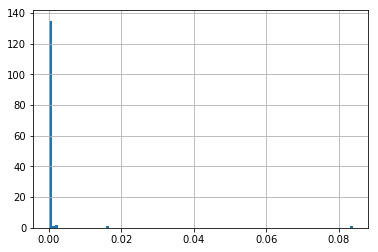

In [180]:
figsize(6, 4)
results.pval.hist(bins=100);

In [181]:
from adjustText import adjust_text

In [182]:
results

g  max_delta     max_ll_x  max_mu_hat  max_s2_t_hat     n  \
0            AFF4   2.806585  5272.938155    0.004126  3.017316e-06  1056   
1            ANKH   4.333765  5957.747389    0.001563  4.119366e-07  1056   
2           CEMIP   3.879517  5806.815909    0.001893  6.246801e-07  1056   
3           CENPF   1.882511  3867.621360    0.007377  2.273729e-05  1056   
4           HERC2   2.907663  5285.965143    0.004206  3.037065e-06  1056   
5           MYH10   2.329497  4970.177605    0.006306  7.215675e-06  1056   
6           NRIP1   3.396875  5521.664382    0.002416  1.118243e-06  1056   
7         PROSER1   5.423482  5684.911916    0.002434  7.801178e-07  1056   
8         SIPA1L3   4.483420  5856.807159    0.001847  5.379442e-07  1056   
9           AFAP1   5.271607  5280.055343    0.002948  8.550306e-07  1056   
10          AGAP1   6.762949  5262.068340    0.003845  1.014044e-06  1056   
11           AGO3   7.052505  5782.940041    0.002046  3.125087e-07  1056   
12           AGPS   5.832297  5518.751286    0.002787  6.138103e-07  1056   
13          AHDC1   5.217226  5187.842721    0.004391  1.444646e-06  1056   
14          ALPK2   4.814838  5545.272589    0.002154  5.167529e-07  1056   
15         AMOTL1   2.794544  4988.390261    0.005226  2.841924e-06  1056   
16        ANKRD52   2.798089  5102.875926    0.004836  2.361885e-06  1056   
17          ASCC3   5.896990  5499.464246    0.002737  6.073130e-07  1056   
18           BUB3   5.073005  5735.986193    0.002228  4.305437e-07  1056   
19        Blank-1  11.351318  6153.013787    0.001130  8.812152e-08  1056   
20       Blank-10  16.017581  5914.537189    0.001637  1.302192e-07  1056   
21        Blank-2   7.755922  6111.018841    0.001137  1.189175e-07  1056   
22        Blank-4   4.774569  6060.130621    0.001166  1.771551e-07  1056   
23        Blank-5  11.997506  5912.544966    0.001551  1.477779e-07  1056   
24        Blank-6   5.634624  5759.534500    0.002098  3.725255e-07  1056   
25        Blank-7  11.045760  5953.763240    0.001568  1.526758e-07  1056   
26        Blank-8   6.557248  6207.282802    0.001066  1.133619e-07  1056   
27        Blank-9  11.955874  6044.872595    0.001350  1.134507e-07  1056   
28      C14orf132   4.242148  5639.052607    0.002344  5.478584e-07  1056   
29           CBX5   5.011442  4935.623566    0.005390  2.280299e-06  1056   
..            ...        ...          ...         ...           ...   ...   
110           CBL  59.621943  5493.039779    0.003319  2.103218e-07  1056   
111        CREBBP  29.561966  4991.682195    0.006621  1.599462e-06  1056   
112         CRTAP  39.631070  5531.528358    0.003183  2.905865e-07  1056   
113          DSEL  45.990477  5854.706996    0.001706  8.082488e-08  1056   
114          FAF2  36.854829  5551.020276    0.002815  2.519296e-07  1056   
115       FAM184B  57.041377  5870.582348    0.001810  7.113638e-08  1056   
116       FAM208B  79.782334  5586.146921    0.002802  1.150349e-07  1056   
117          FBN1  34.551577  5819.134935    0.001917  1.306359e-07  1056   
118         FYCO1  46.288412  5849.468263    0.001837  9.028250e-08  1056   
119        GPR107  56.490794  5550.559814    0.003110  1.954649e-07  1056   
120         IGF2R  54.116261  5551.970398    0.002420  1.346357e-07  1056   
121         ITPR2  54.205481  5749.408588    0.001953  8.857250e-08  1056   
122        KIF13B  22.642628  5472.405814    0.002987  4.623849e-07  1056   
123          NKTR  65.702378  5587.782974    0.002894  1.472067e-07  1056   
124          PHIP  30.765966  5620.177072    0.002488  2.402350e-07  1056   
125        PIK3CA  50.809398  5862.458666    0.001788  7.851377e-08  1056   
126        RNF152  27.409552  5826.311767    0.001947  1.681052e-07  1056   
127        RNF169  52.721334  5500.110260    0.003063  2.067325e-07  1056   
128  RP4-671O14.6  29.575607  5865.912038    0.001771  1.320544e-07  1056   
129          SKP1  82.189909  6039.254234    0.001404  3.107242e-08  1056   
130         

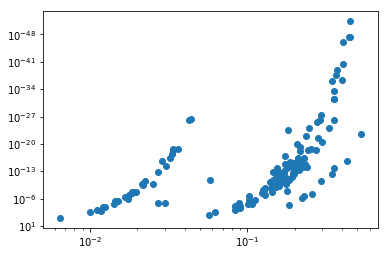

In [183]:
figsize(6, 4)
plt.loglog()
plt.scatter(1./results.max_delta, results.pval)
plt.gca().invert_yaxis();

# texts = []
# idx = results.index[results.g.str.startswith('Blank')]
# for i in idx:
#     if results.loc[i, 'max_delta'] == 0.:
#         continue

#     texts.append(plt.text(results.loc[i, 'max_delta'], results.loc[i, 'pval'], results.loc[i, 'g']))


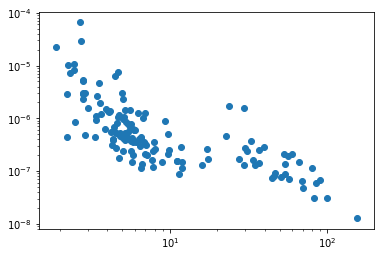

In [184]:
figsize(6, 4)
plt.loglog()
plt.scatter(results.max_delta, results.max_s2_t_hat)

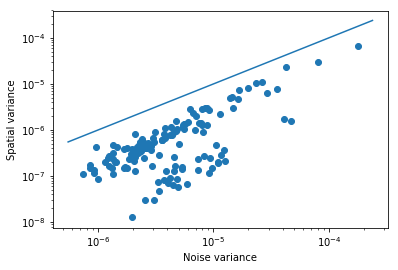

In [185]:
figsize(6, 4)
plt.loglog()
plt.scatter(results.max_delta * results.max_s2_t_hat, results.max_s2_t_hat)
plt.xlabel('Noise variance')
plt.ylabel('Spatial variance');

x = np.linspace(*plt.gca().get_xlim())
plt.plot(x, x);


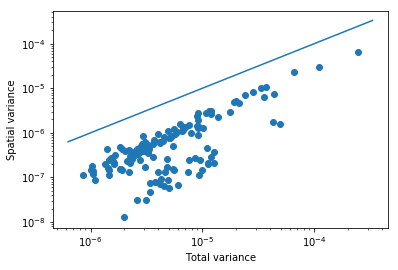

In [186]:
figsize(6, 4)
plt.loglog()
plt.scatter(results.max_delta * results.max_s2_t_hat + results.max_s2_t_hat, results.max_s2_t_hat)
plt.xlabel('Total variance')
plt.ylabel('Spatial variance');

x = np.linspace(*plt.gca().get_xlim())
plt.plot(x, x);


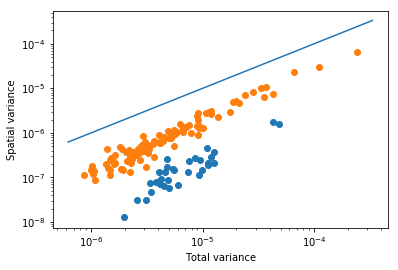

In [187]:
figsize(6, 4)
plt.loglog()
for i, g in results.groupby('model'):
    plt.scatter(g.max_delta * g.max_s2_t_hat + g.max_s2_t_hat, g.max_s2_t_hat)


plt.xlabel('Total variance')
plt.ylabel('Spatial variance');

x = np.linspace(*plt.gca().get_xlim())
plt.plot(x, x);


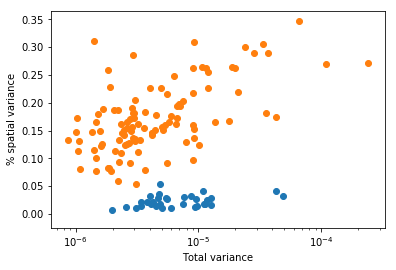

In [188]:
figsize(6, 4)
plt.xscale('log')
results['total_variance'] = results.max_delta * results.max_s2_t_hat + results.max_s2_t_hat

for i, g in results.groupby('model'):
    plt.scatter(g.total_variance, g.max_s2_t_hat / g.total_variance)

plt.xlabel('Total variance')
plt.ylabel('% spatial variance');

# x = np.linspace(*plt.gca().get_xlim())
# plt.plot(x, x);


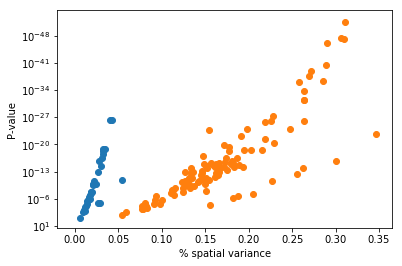

In [189]:
plt.yscale('log')
results['total_variance'] = results.max_delta * results.max_s2_t_hat + results.max_s2_t_hat

for i, g in results.groupby('model'):
    plt.scatter(g.max_s2_t_hat / g.total_variance, g.pval)
    

plt.gca().invert_yaxis();
plt.xlabel('% spatial variance')
plt.ylabel('P-value');

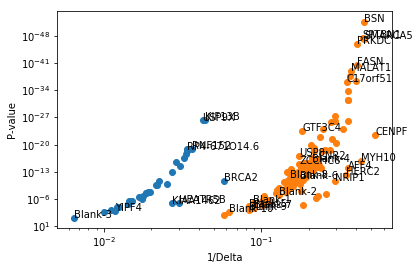

In [190]:
plt.yscale('log')
plt.xscale('log')

for i, g in results.groupby('model'):
    plt.scatter(1. / g.max_delta, g.pval)
    

texts = []
idx = results.index[results.g.str.startswith('Blank')]
for i in idx:
    if results.loc[i, 'l'] == 0.:
        continue

    texts.append(plt.text(1./results.loc[i, 'max_delta'], results.loc[i, 'pval'], results.loc[i, 'g']))
    
idx = top_per_ls.index
for i in idx:
    if results.loc[i, 'l'] == 0.:
        continue

    texts.append(plt.text(1./results.loc[i, 'max_delta'], results.loc[i, 'pval'], results.loc[i, 'g']))
    

plt.gca().invert_yaxis();
plt.xlabel('1/Delta')
plt.ylabel('P-value');

In [199]:
results.query('qval < 0.05').shape

(133, 16)

In [200]:
results.query('qval >= 0.05')

g   max_delta     max_ll_x  max_mu_hat  max_s2_t_hat     n  \
20   Blank-10   16.017581  5914.537189    0.001637  1.302192e-07  1056   
27    Blank-9   11.955874  6044.872595    0.001350  1.134507e-07  1056   
78      SMIM5   17.352980  5803.569127    0.001962  1.682623e-07  1056   
109   Blank-3  154.121098  6128.913558    0.001204  1.269575e-08  1056   
131     TSTD2   89.617517  5746.643665    0.002227  6.648044e-08  1056   
133      UMPS   98.948884  5978.329519    0.001552  3.099708e-08  1056   
136     YIPF4   84.376998  5815.608264    0.002011  5.864123e-08  1056   

         time           l  M model           BIC     max_ll_y         D  \
20   0.002452   54.555049  4    SE -11801.225405  5908.198509  6.338680   
27   0.002571   54.555049  4    SE -12061.896217  6037.333083  7.539512   
78   0.001996   54.555049  4    SE -11579.289281  5798.919024  4.650103   
109  0.002207  205.398037  4   PER -12229.978143  6125.702051  3.211507   
131  0.001848  205.398037  4   PER -11465.438357  5739.448317  7.195348   
133  0.002163  205.398037  4   PER -11928.810064  5972.028869  6.300650   
136  0.001856  398.544628  4   PER -11603.367553  5808.711598  6.896666   

         pval      qval  total_variance  
20   0.002305  0.322727        0.000002  
27   0.000553  0.077462        0.000001  
78   0.016551  1.000000        0.000003  
109  0.083926  1.000000        0.000002  
131  0.000834  0.116793        0.000006  
133  0.002411  0.337551        0.000003  
136  0.001190  0.166626        0.000005

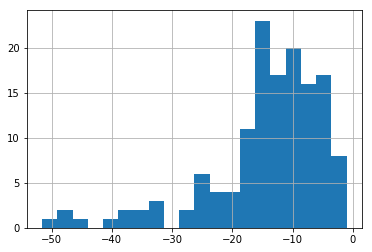

In [191]:
np.log10(results.pval).hist(bins=20);

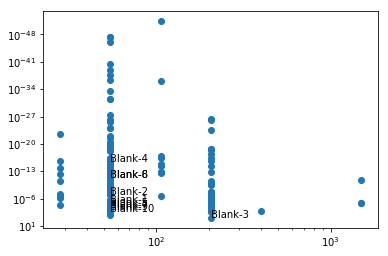

In [192]:
figsize(6, 4)
plt.loglog()
plt.scatter(results.l, results.pval)
plt.gca().invert_yaxis();

texts = []
idx = results.index[results.g.str.startswith('Blank')]
for i in idx:
    if results.loc[i, 'l'] == 0.:
        continue

    texts.append(plt.text(results.loc[i, 'l'], results.loc[i, 'pval'], results.loc[i, 'g']))


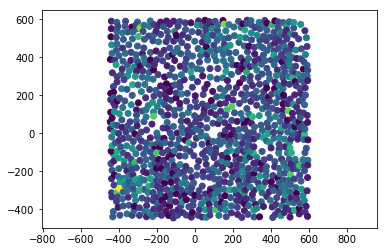

In [193]:
plt.scatter(sample_info.abs_X, sample_info.abs_Y, c=dfm['Blank-1']);
plt.axis('equal');

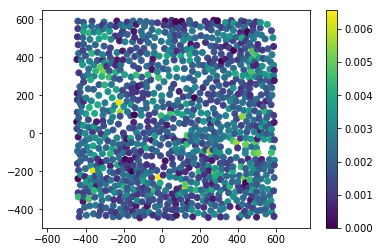

In [194]:
plt.scatter(sample_info.abs_X, sample_info.abs_Y, c=dfm['Blank-6']);
plt.axis('equal');
plt.colorbar();

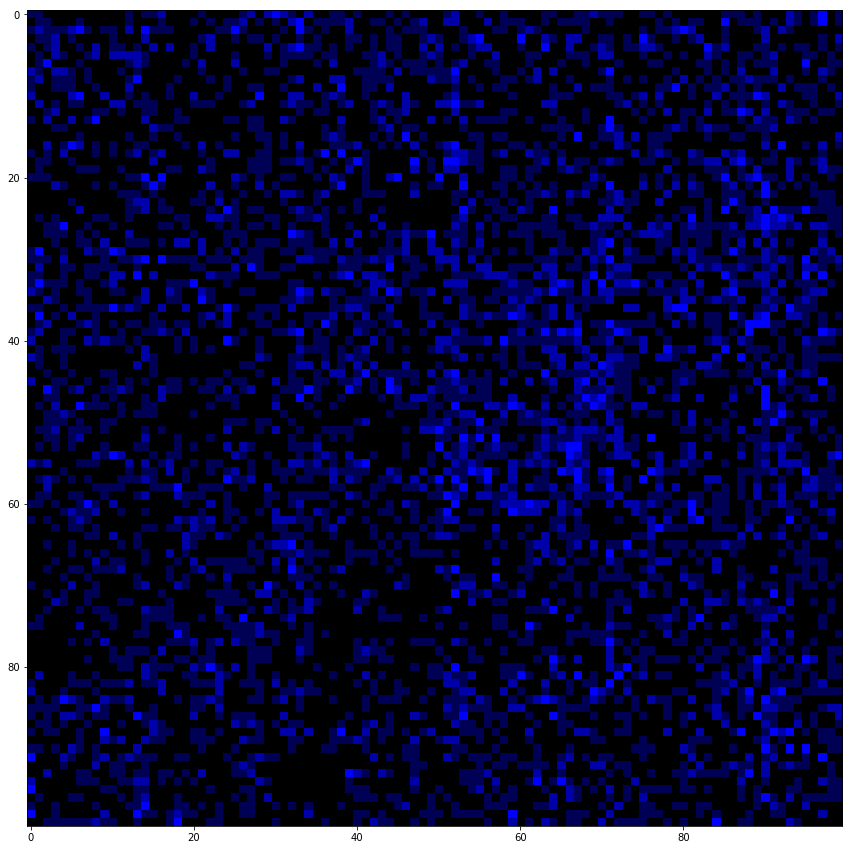

In [134]:
figsize(15, 15)
# tmp = middle.query('gene == "MALAT1"')
tmp = middle
N = 100

grid_counts = tmp.groupby( [pd.cut( tmp['abs_X'], N), pd.cut( tmp['abs_Y'], N)] ).count()['abs_X'].to_frame()
img_mat = grid_counts.unstack()

final_img = np.zeros((img_mat.shape + (3,)))

# final_img[:, :, 1] = np.nan

# final_img[:, :, 0] = img_mat.replace(np.nan, 0)


tmp = middle.query('name == "BSN"')

grid_counts = tmp.groupby( [pd.cut( tmp['abs_X'], N), pd.cut( tmp['abs_Y'], N)] ).count()['abs_X'].to_frame()
img_mat = grid_counts.unstack()

final_img[:, :, 2] = img_mat.replace(np.nan, 0)

# final_img[:, :, 0] /= final_img[:, :, 0].max() * 1.
final_img[:, :, 2] /= final_img[:, :, 2].max() * 0.5

plt.imshow(final_img);
# plt.imshow(np.log10(final_img + 1));

In [135]:
img_mat.max()

       abs_Y               
abs_X  (-450.85, -439.303]     3.0
       (-439.303, -428.806]    4.0
       (-428.806, -418.309]    6.0
       (-418.309, -407.812]    2.0
       (-407.812, -397.316]    3.0
       (-397.316, -386.819]    3.0
       (-386.819, -376.322]    3.0
       (-376.322, -365.825]    3.0
       (-365.825, -355.328]    3.0
       (-355.328, -344.831]    3.0
       (-344.831, -334.334]    3.0
       (-334.334, -323.837]    2.0
       (-323.837, -313.34]     2.0
       (-313.34, -302.843]     3.0
       (-302.843, -292.346]    4.0
       (-292.346, -281.85]     3.0
       (-281.85, -271.353]     4.0
       (-271.353, -260.856]    4.0
       (-260.856, -250.359]    5.0
       (-250.359, -239.862]    2.0
       (-239.862, -229.365]    3.0
       (-229.365, -218.868]    3.0
       (-218.868, -208.371]    3.0
       (-208.371, -197.874]    4.0
       (-197.874, -187.377]    3.0
       (-187.377, -176.881]    3.0
       (-176.881, -166.384]    4.0
       (-166.384, -155.887]